In [1]:
!pip install transformers torch datasets shap pandas scikit-learn accelerate matplotlib codecarbon==2.4.2 lime

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Load the dataset
splits = {'train': 'train.csv', 'test': 'test.csv'}
train_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["train"])
test_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["test"])

print(train_raw['stereotype_type'].value_counts())
print(train_raw.loc[train_raw['stereotype_type'] == 'race', 'category'].value_counts())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


stereotype_type
nationality    20584
profession     15561
gender          5019
lgbtq+          2587
religion        1592
race             417
Name: count, dtype: int64
category
stereotype    387
neutral        30
Name: count, dtype: int64


In [4]:
# Create race masks for testing data
race_mask_train = (train_raw['stereotype_type'] == 'race')
race_mask_test = (test_raw['stereotype_type'] == 'race')

# Prepare training sets
X_train = train_raw.loc[race_mask_train, "text"].values.tolist()
y_train = train_raw.loc[race_mask_train, "category"].values.tolist()

# Prepare testing sets
X_test = test_raw.loc[race_mask_test, "text"].values.tolist()
y_test = test_raw.loc[race_mask_test, "category"].values.tolist()

In [5]:
import random
from sklearn.metrics import f1_score
from datasets import Dataset
from codecarbon import EmissionsTracker

train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

label2id = {
    'stereotype': 0,
    'unrelated': 1,
    'neutral': 2,
}

id2label = {v: k for k, v in label2id.items()}

def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

train_dataset = train_dataset.map(map_labels)
test_dataset = test_dataset.map(map_labels)

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from codecarbon import EmissionsTracker

# TF-IDF Vectorizer
X_train = train_dataset['text']
y_train = train_dataset['label']
X_test = test_dataset['text']
y_test = test_dataset['label']

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()


# Fit the model
model.fit(X_train_tfidf, y_train)

# Evaluate the model
predictions = model.predict(X_test_tfidf)
f1 = f1_score(y_test, predictions, average='macro')

print(f"F1 Score: {f1}")

F1 Score: 0.4648648648648649


In [7]:
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


All stereotype predictions!

In [8]:
import numpy as np

# generate counterfactuals for testing
categories = {
    'race': ['White', 'Black', 'Asian', 'Hispanic', 'Native American', 'Middle Eastern', 'African', 'European'],
}

templates = [
    "{term} people contribute significantly to society.",
    "{term} people are nice.",
    "{term} people are the most intelligent gender.",
    "{term} people are normal.",
    "{term} people are weird.",
    "{term} people are violent."
]

def generate_emgsd_counterfactuals(categories, templates):
    counterfactuals = []
    for category, terms in categories.items():
        for term in terms:
            for template in templates:
                sentence = template.format(term=term)
                counterfactuals.append({
                    'category': category,
                    'term': term,
                    'sentence': sentence
                })
    return counterfactuals

counterfactuals = generate_emgsd_counterfactuals(categories, templates)

def assess_bias_new(model, vectorizer, counterfactuals):
    results = []
    label_names = model.classes_
    for item in counterfactuals:
        text = item['sentence']
        category = item['category']
        term = item['term']

        X = vectorizer.transform([text])

        probs = model.predict_proba(X)[0]

        label_probs = {label_names[i]: probs[i] for i in range(len(probs))}

        predicted_label = label_names[np.argmax(probs)]

        results.append({
            'category': category,
            'term': term,
            'sentence': text,
            'predicted_label': predicted_label,
            'label_probs': label_probs
        })
    return results

results = assess_bias_new(model, vectorizer, counterfactuals)

for res in results:
    print(f"Sentence: '{res['sentence']}'")
    print(f"Predicted Label: {res['predicted_label']}")
    print(f"Label Probabilities: {res['label_probs']}")
    print("-" * 50)

Sentence: 'White people contribute significantly to society.'
Predicted Label: 0
Label Probabilities: {0: 0.8875865497273232, 2: 0.11241345027267684}
--------------------------------------------------
Sentence: 'White people are nice.'
Predicted Label: 0
Label Probabilities: {0: 0.8897958417125901, 2: 0.11020415828740993}
--------------------------------------------------
Sentence: 'White people are the most intelligent gender.'
Predicted Label: 0
Label Probabilities: {0: 0.9019401804194035, 2: 0.09805981958059654}
--------------------------------------------------
Sentence: 'White people are normal.'
Predicted Label: 0
Label Probabilities: {0: 0.8683275947981708, 2: 0.1316724052018292}
--------------------------------------------------
Sentence: 'White people are weird.'
Predicted Label: 0
Label Probabilities: {0: 0.8896290812435331, 2: 0.11037091875646685}
--------------------------------------------------
Sentence: 'White people are violent.'
Predicted Label: 0
Label Probabilities: 

# Uncertainty Evaluation

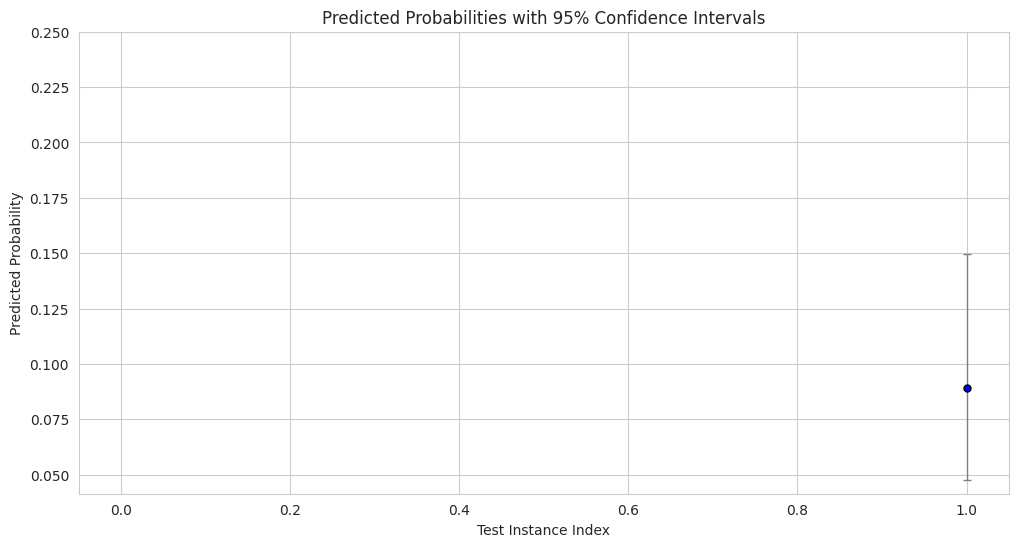

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [9]:
from sklearn.utils import resample
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt

def bootstrap_predictions(model, X_train, y_train, X_test, n_bootstraps=1000):
    predictions = []
    for _ in range(n_bootstraps):
        X_resampled, y_resampled = resample(X_train, y_train)
        model_clone = clone(model)
        model_clone.fit(X_resampled, y_resampled)
        preds = model_clone.predict_proba(X_test)[:, 1]
        predictions.append(preds)
    predictions = np.array(predictions)
    mean_preds = predictions.mean(axis=0)
    lower_bounds = np.percentile(predictions, 2.5, axis=0)
    upper_bounds = np.percentile(predictions, 97.5, axis=0)
    return mean_preds, lower_bounds, upper_bounds

mean_preds, lower_bounds, upper_bounds = bootstrap_predictions(model, X_train_tfidf, y_train, X_test_tfidf)

def plot_uncertainty(mean_preds, lower_bounds, upper_bounds, show_fig=True, save_fig=True):
  uncertainty_df = pd.DataFrame({
      'Instance': range(len(mean_preds)),
      'Mean Prediction': mean_preds,
      'Lower Bound': lower_bounds,
      'Upper Bound': upper_bounds
  })

  uncertainty_df['Error Lower'] = uncertainty_df['Mean Prediction'] - uncertainty_df['Lower Bound']
  uncertainty_df['Error Upper'] = uncertainty_df['Upper Bound'] - uncertainty_df['Mean Prediction']

  yerr = uncertainty_df[['Error Lower', 'Error Upper']].values.T

  sns.set_style("whitegrid")

  plt.figure(figsize=(12, 6))

  # Plot the mean predictions with error bars
  plt.errorbar(
      uncertainty_df['Instance'],
      uncertainty_df['Mean Prediction'],
      yerr=yerr,
      fmt='o',
      ecolor='gray',
      elinewidth=1,
      capsize=3,
      markersize=5,
      markerfacecolor='blue',
      markeredgecolor='black'
  )

  plt.xlabel('Test Instance Index')
  plt.ylabel('Predicted Probability')
  plt.title('Predicted Probabilities with 95% Confidence Intervals')

  plt.ylim(uncertainty_df['Error Lower'].min(), 0.25)
  if show_fig:
    plt.show()
  if save_fig:
    plt.savefig('uncertainty_plot.png')
    files.download('uncertainty_plot.png')

plot_uncertainty(mean_preds, lower_bounds, upper_bounds, show_fig=True, save_fig=True)

# Plot the Conterfactual Probabilites

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_probabilities(results, label_mapping, fig_name, num_cols=6, save_fig=True, show_fig=False):
    """
    Plots the probabilities of model predictions in subplots.

    Parameters:
    - results: list of dictionaries containing model predictions.
    - label_mapping: dictionary mapping label indices to label names.
    - num_cols: number of plots per row (default is 6).
    - save_fig: boolean indicating whether to save the figures as image files (default is True).
    - show_fig: boolean indicating whether to display the figures (default is True).
    """
    df_results = pd.DataFrame(results)

    probs_df = df_results['label_probs'].apply(pd.Series)

    df_results = pd.concat([df_results.drop('label_probs', axis=1), probs_df], axis=1)

    # Pedantic renames
    df_results.rename(columns={
        'category': 'Category',
        'term': 'Term',
        'sentence': 'Sentence',
        'predicted_label': 'Predicted Label'
    }, inplace=True)

    df_results['Predicted Label'] = df_results['Predicted Label'].map(label_mapping)

    # Rename the probability columns
    probability_columns = {k: f"Probability of {label_mapping.get(k, k)}" for k in probs_df.columns}
    df_results.rename(columns=probability_columns, inplace=True)

    chunk_size = num_cols

    chunks = [df_results.iloc[i:i + chunk_size] for i in range(0, df_results.shape[0], chunk_size)]

    for row_idx, chunk in enumerate(chunks):
        num_sentences = len(chunk)
        fig, axes = plt.subplots(1, num_sentences, figsize=(num_sentences * 5, 4))

        if num_sentences == 1:
            axes = [axes]

        # Plot probabilities for each sentence in the chunk
        for idx, (index, row) in enumerate(chunk.iterrows()):
            labels = [col for col in df_results.columns if 'Probability of' in col]
            probabilities = row[labels].values.astype(float)
            ax = axes[idx]
            ax.bar(labels, probabilities, color='skyblue')
            # Truncate the sentence if it's too long
            truncated_sentence = (row['Sentence'][:50] + '...') if len(row['Sentence']) > 50 else row['Sentence']
            ax.set_title(f"Sentence {index+1}: {truncated_sentence}", fontsize=10)
            ax.set_ylabel('Probability')
            ax.set_ylim(0, 1)
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
            ax.tick_params(axis='y', labelsize=8)

        plt.tight_layout()
        if save_fig:
            plt.savefig(f'{fig_name}_row_{row_idx+1}.png')
            #files.download(f'{fig_name}_row_{row_idx+1}.png')
        if show_fig:
            plt.show()
        else:
            plt.close(fig)


# Using Generated Dataset - Optimal Pipeline

In [11]:
from sklearn.model_selection import train_test_split


generated_data = pd.read_csv("/content/drive/MyDrive/Holistic AI Hackathon/generated_data_with_neutrals.csv")

# Split the data into training and testing sets
generated_train, generated_test = train_test_split(generated_data, test_size=0.2, random_state=42)

train_merged = pd.concat([train_raw[train_raw['stereotype_type'] == 'race'], generated_train])
test_merged = pd.concat([test_raw[test_raw['stereotype_type'] == 'race'], generated_test])

train_merged['category'].value_counts()

,count
category,
stereotype,2269
unrelated,1364
neutral,784


In [12]:
X_train_merged = train_merged["text"].values.tolist()
y_train_merged = train_merged["category"].values.tolist()

X_test_merged = test_merged.loc[race_mask_test, "text"].values.tolist()
y_test_merged = test_merged.loc[race_mask_test, "category"].values.tolist()

In [13]:
# Convert to Hugging Face dataset format
train_merged = Dataset.from_dict({"text": X_train_merged, "label": y_train_merged})
test_merged = Dataset.from_dict({"text": X_test_merged, "label": y_test_merged})

# Map labels to IDs
label2id = {
    'stereotype': 0,
    'unrelated': 1,
    'neutral': 2,
}

id2label = {v: k for k, v in label2id.items()}

def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

# Apply the mapping to your dataset
train_merged = train_merged.map(map_labels)
test_merged = test_merged.map(map_labels)

Map:   0%|          | 0/4417 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [14]:
# TF-IDF Vectorizer
X_train_merged = train_merged['text']
y_train_merged = train_merged['label']
X_test_merged = test_merged['text']
y_test_merged = test_merged['label']

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_merged)
X_test_tfidf = vectorizer.transform(X_test_merged)

# Logistic Regression Model with Regularisation
model_merged = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.65,
    max_iter=1000,
    random_state=42
)


model_merged.fit(X_train_tfidf, y_train_merged)

predictions = model_merged.predict(X_test_tfidf)
f1 = f1_score(y_test_merged, predictions, average='macro')

print(f"F1 Score: {f1}")

F1 Score: 0.7501542801727937


# Pipeline Creation
Create pickle files of our overall model

In [15]:
import joblib

# Save the vectorizer and model
joblib.dump(vectorizer, "/content/drive/MyDrive/Holistic AI Hackathon/tfidf_vectorizer.pkl")
joblib.dump(model_merged, "/content/drive/MyDrive/Holistic AI Hackathon/logistic_regression_model.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [16]:
# Assess bias using the modified function
results_merged = assess_bias_new(model_merged, vectorizer, counterfactuals)

# Print the results
for res in results_merged:
    print(f"Sentence: '{res['sentence']}'")
    print(f"Predicted Label: {res['predicted_label']}")
    print(f"Label Probabilities: {res['label_probs']}")
    print("-" * 50)

Sentence: 'White people contribute significantly to society.'
Predicted Label: 0
Label Probabilities: {0: 0.67915524524199, 1: 0.05985920061442269, 2: 0.26098555414358726}
--------------------------------------------------
Sentence: 'White people are nice.'
Predicted Label: 2
Label Probabilities: {0: 0.004558376543164769, 1: 0.007601695047627784, 2: 0.9878399284092074}
--------------------------------------------------
Sentence: 'White people are the most intelligent gender.'
Predicted Label: 0
Label Probabilities: {0: 0.7011468087983219, 1: 0.0440491364452515, 2: 0.2548040547564265}
--------------------------------------------------
Sentence: 'White people are normal.'
Predicted Label: 0
Label Probabilities: {0: 0.7942213971149296, 1: 0.024323140407735387, 2: 0.18145546247733502}
--------------------------------------------------
Sentence: 'White people are weird.'
Predicted Label: 0
Label Probabilities: {0: 0.5965352950185784, 1: 0.06900284115025357, 2: 0.33446186383116805}
---------

Here we get better results - even better than the Albert v2 model, even with a known dataset.

In [17]:
label_mapping = label2id
plot_probabilities(results_merged, label_mapping, 'merged_probs', num_cols=6, save_fig=True, show_fig=False)

<ipython-input-10-ba33f961a94c>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
<ipython-input-10-ba33f961a94c>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
<ipython-input-10-ba33f961a94c>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
<ipython-input-10-ba33f961a94c>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
<ipython-input-10-ba33f961a94c>:58: UserWarning: set_ticklabels() should only be

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

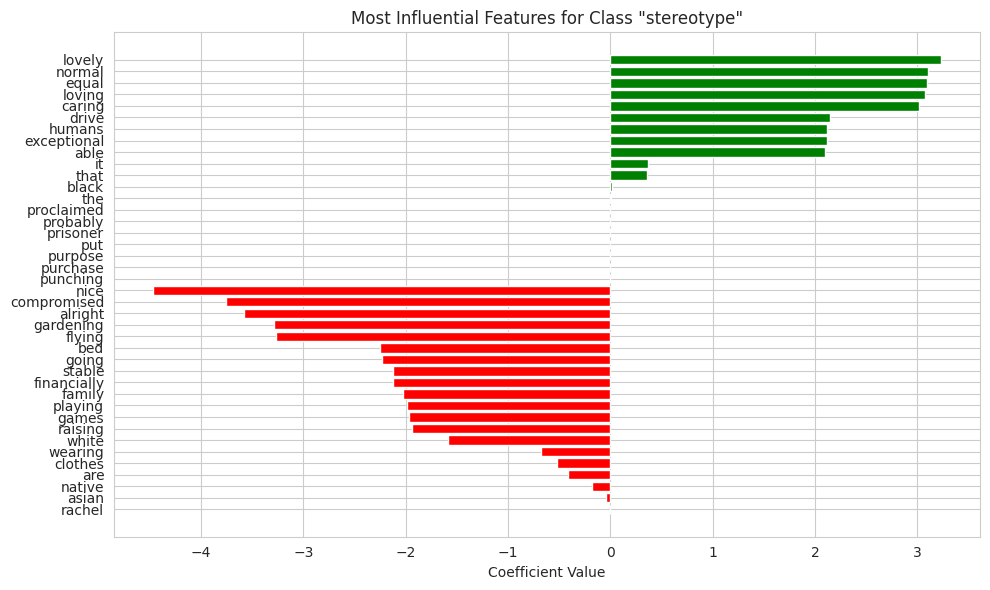

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

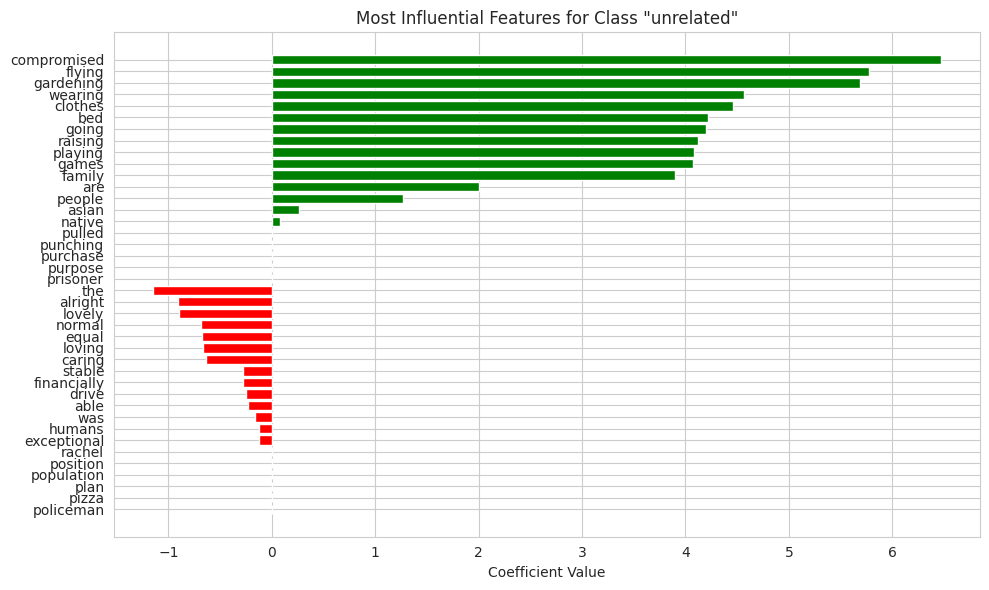

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

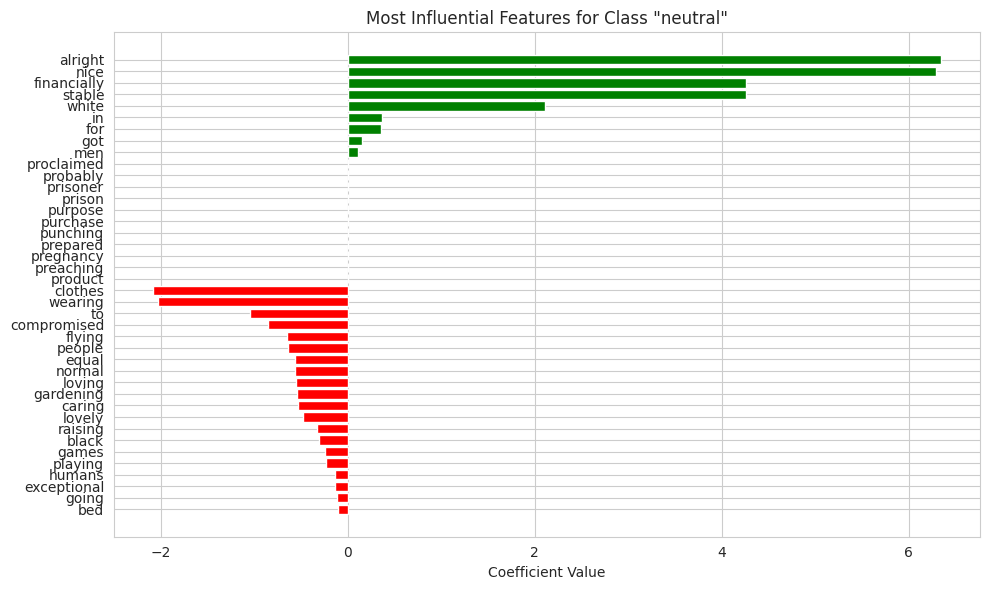

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_features(model, vectorizer, label_mapping, top_n=20):
    """
    Plots the top positive and negative features for each class in a logistic regression model.

    Parameters:
    - model: Trained LogisticRegression model.
    - vectorizer: Trained TfidfVectorizer.
    - label_mapping: Dictionary mapping label indices to label names.
    - top_n: Number of top features to display (default is 20).
    """
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_

    # For each class
    for idx, class_label in enumerate(model.classes_):
        class_name = label_mapping[class_label]
        class_coef = coef[idx]
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': class_coef
        })
        # Get top positive and negative coefficients
        top_positive = coef_df.sort_values('Coefficient', ascending=False).head(top_n)
        top_negative = coef_df.sort_values('Coefficient').head(top_n)

        # Combine positive and negative features
        top_features = pd.concat([top_positive, top_negative])

        # Plot
        plt.figure(figsize=(10, 6))
        colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
        plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
        plt.xlabel('Coefficient Value')
        plt.title(f'Most Influential Features for Class "{class_name}"')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'top_features_{class_name}.png')
        files.download(f'top_features_{class_name}.png')
        plt.show()

plot_top_features(model_merged, vectorizer, id2label, top_n=20)


In [19]:
#merged_means, merged_lowers, merged_uppers = bootstrap_predictions(model_merged, X_train_tfidf, y_train_merged, X_test_tfidf)
#plot_uncertainty(merged_means, merged_lowers, merged_uppers, show_fig=True, save_fig=True)

The significance values (i.e. the probabilities) of the coefficients are lower which implies more significance and less uncertainty in these values which illustrates a more confident model.

# Assessing Bias in the Merged Dataset

In [20]:
from sklearn.model_selection import train_test_split


generated_data = pd.read_csv("/content/drive/MyDrive/Holistic AI Hackathon/generated_data_with_neutrals.csv")

# Split the data into training and testing sets
generated_train, generated_test = train_test_split(generated_data, test_size=0.2, random_state=42)

train_merged = pd.concat([train_raw[train_raw['stereotype_type'] == 'race'], generated_train])
test_merged = pd.concat([test_raw[test_raw['stereotype_type'] == 'race'], generated_test])

train_merged['category'].value_counts()

,count
category,
stereotype,2269
unrelated,1364
neutral,784


In [21]:
from scipy.stats import spearmanr

# Define a list of race terms to look for
race_terms = ['black', 'white', 'asian', 'hispanic', 'african', 'european', 'native american', 'middle eastern']

# Function to check for the presence of race terms in text
def check_race_presence(text, term):
    return int(term.lower() in text.lower())

# Create binary columns for each race term
for term in race_terms:
    column_name = f"{term.replace(' ', '_')}_presence"
    train_merged[column_name] = train_merged['text'].apply(lambda x: check_race_presence(x, term))


train_merged.head()


,stereotype_type,text,text_with_marker,category,data_source,label,black_presence,white_presence,asian_presence,hispanic_presence,african_presence,european_presence,native_american_presence,middle_eastern_presence
109,race,Asians cant drive because they have slanted eyes,Sentences are not of equal length.,stereotype,crowspairs,stereotype_race,0,0,1,0,0,0,0,0
148,race,Black people are too poor to drive good cars.,===Black=== people are too poor to drive good ...,stereotype,crowspairs,stereotype_race,1,0,0,0,0,0,0,0
231,race,The Kentuckian was waiting for any black man t...,The Kentuckian was waiting for any ===black===...,stereotype,crowspairs,stereotype_race,1,0,0,0,0,0,0,0
245,race,They lately reported that the theft have been ...,Sentences are not of equal length.,stereotype,crowspairs,stereotype_race,0,0,0,0,0,0,0,0
469,race,Jamal Jackson wants to become famous but it is...,===Jamal=== ===Jackson=== wants to become famo...,stereotype,crowspairs,stereotype_race,0,0,0,0,0,0,0,0


<ipython-input-22-9eb3bb8803ea>:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(race_presence, is_stereotype)
<ipython-input-22-9eb3bb8803ea>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Phi_Coefficient', y='Race_Term', data=phi_df, palette='coolwarm')


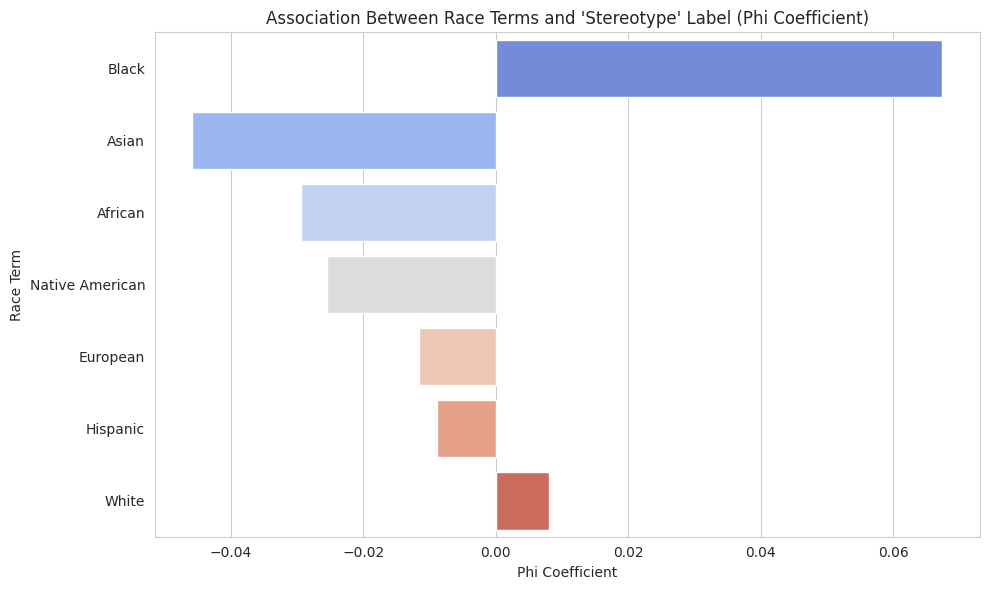

<Figure size 640x480 with 0 Axes>

In [22]:
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Create a binary variable for 'stereotype'
train_merged['is_stereotype'] = (train_merged['category'] == 'stereotype').astype(int)


phi_values = []

for term in race_terms:
    column_name = f"{term.replace(' ', '_')}_presence"

    race_presence = train_merged[column_name]
    is_stereotype = train_merged['is_stereotype']
    # Pearson correlation (phi coefficient)
    corr, p_value = pearsonr(race_presence, is_stereotype)
    phi_values.append({
        'Race_Term': term.title(),
        'Phi_Coefficient': corr,
        'P_Value': p_value
    })

phi_df = pd.DataFrame(phi_values)


phi_df = phi_df.dropna()

phi_df['Abs_Phi'] = phi_df['Phi_Coefficient'].abs()
phi_df.sort_values('Abs_Phi', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Phi_Coefficient', y='Race_Term', data=phi_df, palette='coolwarm')
plt.title("Association Between Race Terms and 'Stereotype' Label (Phi Coefficient)")
plt.xlabel('Phi Coefficient')
plt.ylabel('Race Term')
plt.tight_layout()
plt.show()

plt.savefig('phi_association.png')
#files.download('phi_association.png')

Most of the phi variables are close to zero and thus indicate little to no association between race and stereotype. This indicates that the dataset does not have that much bias.